2025-06-01 08:22:19.975722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 08:22:19.978524: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 08:22:20.025224: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 08:22:20.050366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748762540.092838    5383 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748762540.10

Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


2025-06-01 08:22:22.530309: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-01 08:22:23.082267: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.81185, saving model to efficientnetb0_finetuned.keras
1088/1088 - 88s - 80ms/step - accuracy: 0.6959 - loss: 0.7079 - val_accuracy: 0.8118 - val_loss: 0.4220 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_accuracy improved from 0.81185 to 0.85807, saving model to efficientnetb0_finetuned.keras
1088/1088 - 81s - 74ms/step - accuracy: 0.7906 - loss: 0.4884 - val_accuracy: 0.8581 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 3/15

Epoch 3: val_accuracy improved from 0.85807 to 0.88477, saving model to efficientnetb0_finetuned.keras
1088/1088 - 81s - 74ms/step - accuracy: 0.8294 - loss: 0.4107 - val_accuracy: 0.8848 - val_loss: 0.2849 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_accuracy improved from 0.88477 to 0.88997, saving model to efficientnetb0_finetuned.keras
1088/1088 - 80s - 74ms/step - accuracy: 0.8628 - loss: 0.3433 - val_accuracy: 0.8900 - val_loss: 0.2603 - learning_rate: 1.0000e-04
Epoch 5/15

Epo

2025-06-01 08:43:01.152811: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


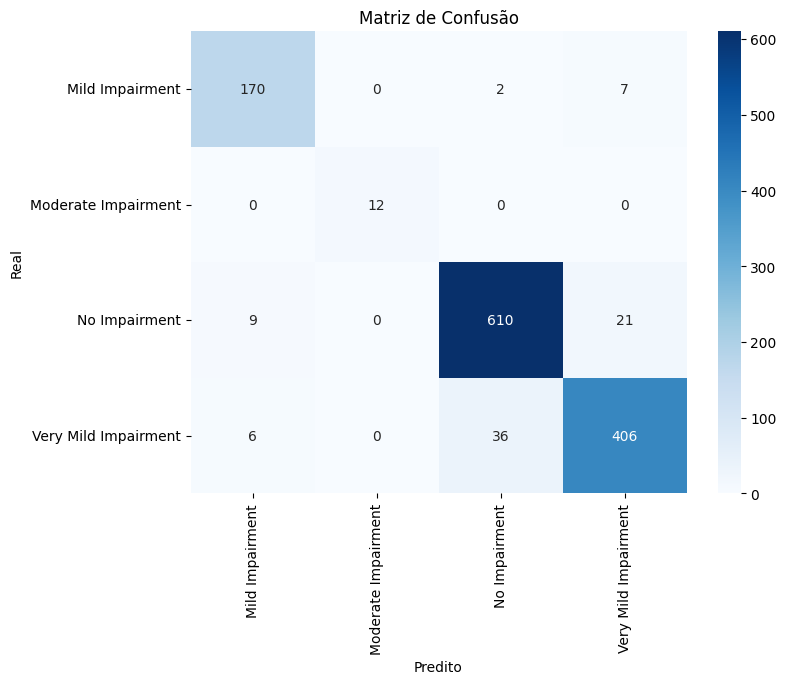


🔥 AUC Score (macro): 0.9929


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

img_size = (224, 224)
batch_size = 8
epochs = 15

train_dir = './data/train'
val_dir = './data/val'
test_dir = './data/test'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds_raw = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size)

class_names = train_ds_raw.class_names
num_classes = len(class_names)

train_ds = train_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)


y_train = list(itertools.chain(*[y.numpy().tolist() for _, y in train_ds_raw]))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x) 
output = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint("efficientnetb0_finetuned.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)


model.save("efficientnetb0_finetuned.keras")

best_model = tf.keras.models.load_model("efficientnetb0_finetuned.keras")

test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

y_true, y_pred, y_probs = [], [], []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_probs.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("\n📋 Classification Reporefficientnetb0_finetunedt:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
auc = roc_auc_score(y_true_bin, np.array(y_probs), multi_class='ovr')
print(f"\n🔥 AUC Score (macro): {auc:.4f}")


In [2]:
img_size = (224, 224)
batch_size = 8

train_dir = './data/train'
val_dir = './data/val'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)

train_ds = train_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
y_train = list(itertools.chain(*[y.numpy().tolist() for _, y in train_ds_raw]))
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = load_model("efficientnetb0_finetuned.keras")

model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
    ModelCheckpoint("efficientnetb0_finetuned_full.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

def combine_histories(h1, h2):
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history[key]
    return combined

full_history = combine_histories(history1, history2)


model.save("efficientnetb0_finetuned_full.keras")


Found 8704 files belonging to 4 classes.
Found 1536 files belonging to 4 classes.
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.97917, saving model to efficientnetb0_finetuned_full.keras
1088/1088 - 85s - 78ms/step - accuracy: 0.9752 - loss: 0.0695 - val_accuracy: 0.9792 - val_loss: 0.0601 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_accuracy improved from 0.97917 to 0.98242, saving model to efficientnetb0_finetuned_full.keras
1088/1088 - 80s - 73ms/step - accuracy: 0.9804 - loss: 0.0584 - val_accuracy: 0.9824 - val_loss: 0.0556 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.98242
1088/1088 - 80s - 74ms/step - accuracy: 0.9802 - loss: 0.0595 - val_accuracy: 0.9818 - val_loss: 0.0550 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98242 to 0.98438, saving model to efficientnetb0_finetuned_full.keras
1088/1088 - 80s - 74ms/step - accuracy: 0.9824 - loss: 0.0537 - val_accuracy: 0.9844 - val_loss: 0.053


✅ Train Accuracy: 1.0000 | Loss: 0.0017

📋 Classification Report – Train:
                      precision    recall  f1-score   support

     Mild Impairment       1.00      1.00      1.00      2176
 Moderate Impairment       1.00      1.00      1.00      2176
       No Impairment       1.00      1.00      1.00      2176
Very Mild Impairment       1.00      1.00      1.00      2176

            accuracy                           1.00      8704
           macro avg       1.00      1.00      1.00      8704
        weighted avg       1.00      1.00      1.00      8704



2025-06-01 08:59:27.299501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


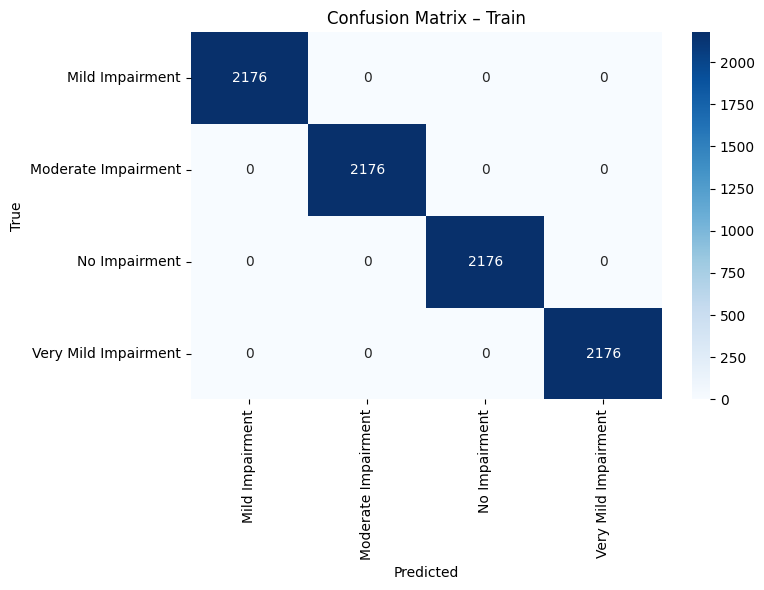


🔥 AUC Score (macro) – Train: 1.0000

✅ Validation Accuracy: 0.9850 | Loss: 0.0492

📋 Classification Report – Validation:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.98      0.98       384
 Moderate Impairment       1.00      1.00      1.00       384
       No Impairment       0.99      0.98      0.98       384
Very Mild Impairment       0.97      0.98      0.98       384

            accuracy                           0.99      1536
           macro avg       0.99      0.99      0.99      1536
        weighted avg       0.99      0.99      0.99      1536



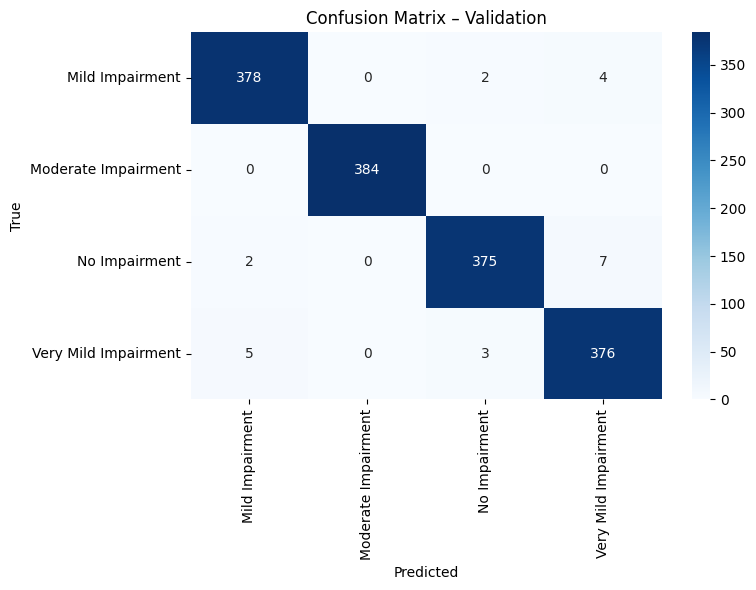


🔥 AUC Score (macro) – Validation: 0.9992

✅ Test Accuracy: 0.9617 | Loss: 0.1192

📋 Classification Report – Test:
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.96      0.95       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.98      0.96      0.97       640
Very Mild Impairment       0.95      0.96      0.95       448

            accuracy                           0.96      1279
           macro avg       0.97      0.97      0.97      1279
        weighted avg       0.96      0.96      0.96      1279



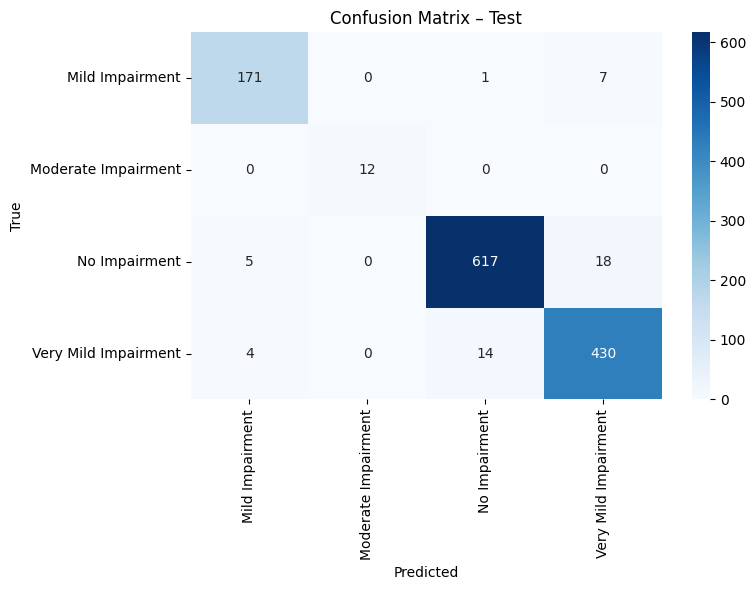


🔥 AUC Score (macro) – Test: 0.9961


In [3]:
model = load_model("efficientnetb0_finetuned_full.keras")

# Função para avaliação
def evaluate_model(dataset, dataset_name):
    loss, acc = model.evaluate(dataset, verbose=0)
    print(f"\n✅ {dataset_name} Accuracy: {acc:.4f} | Loss: {loss:.4f}")

    y_true, y_pred, y_probs = [], [], []

    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        y_probs.extend(preds)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(y.numpy())

    print(f"\n📋 Classification Report – {dataset_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {dataset_name}")
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    auc = roc_auc_score(y_true_bin, np.array(y_probs), multi_class='ovr')
    print(f"\n🔥 AUC Score (macro) – {dataset_name}: {auc:.4f}")

# Avaliar nos três conjuntos
evaluate_model(train_ds, "Train")
evaluate_model(val_ds, "Validation")
evaluate_model(test_ds, "Test")

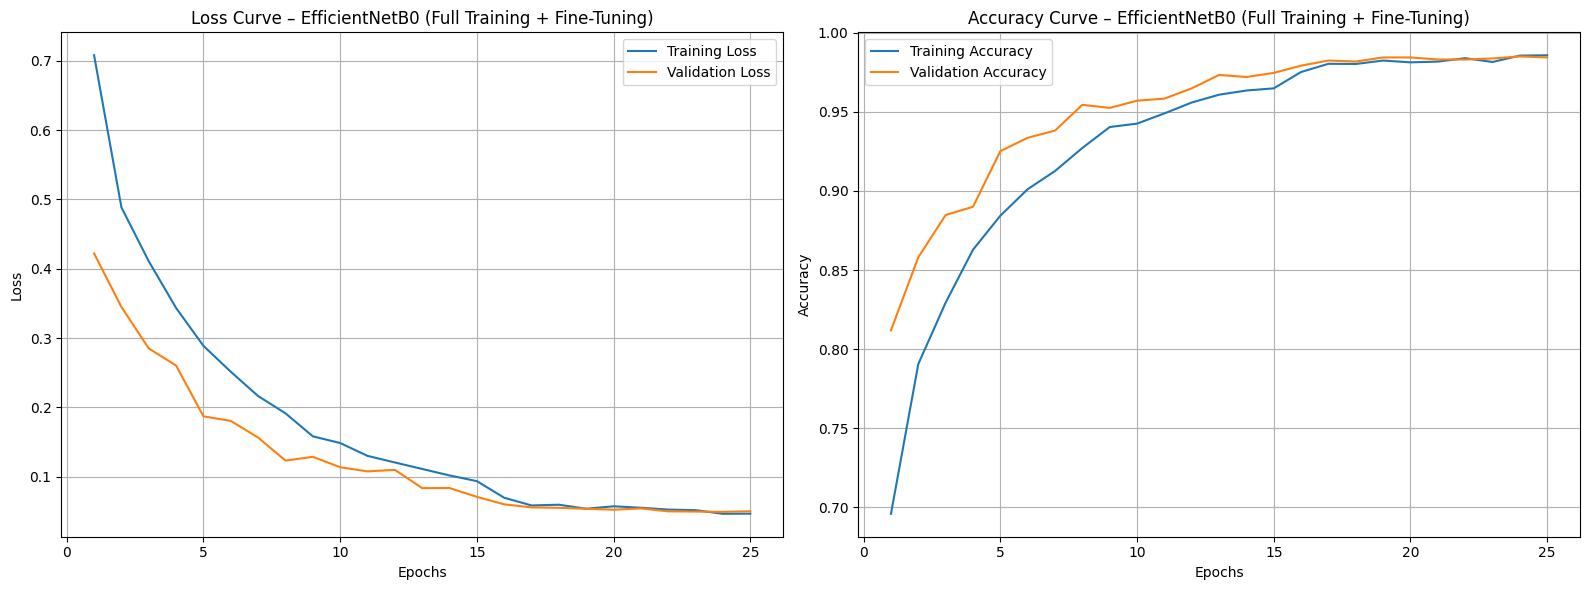

In [4]:
epochs_range = range(1, len(full_history['loss']) + 1)

plt.figure(figsize=(16, 6))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(epochs_range, full_history['loss'], label='Training Loss')
plt.plot(epochs_range, full_history['val_loss'], label='Validation Loss')
plt.title('Loss Curve – EfficientNetB0 (Full Training + Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs_range, full_history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve – EfficientNetB0 (Full Training + Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
